<a href="https://colab.research.google.com/github/yyguo50170/dlg/blob/main/Deep_Leakage_from_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

2.0.1+cu118 0.15.2+cu118


In [2]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx):
    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

    history = []
    for iters in range(300):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            # grad_diff = grad_diff / grad_count * 1000
            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        if iters % 10 == 0:
            current_loss = closure()
            print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))

    plt.figure(figsize=(12, 8))
    for i in range(30):
      plt.subplot(3, 10, i + 1)
      plt.imshow(history[i * 10])
      plt.title("iter=%d" % (i * 10))
      plt.axis('off')
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

100%|██████████| 169001437/169001437 [00:01<00:00, 95744700.83it/s]


Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch
Running on cuda


In [3]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

GT label is 84. 
Onehot label is 84.


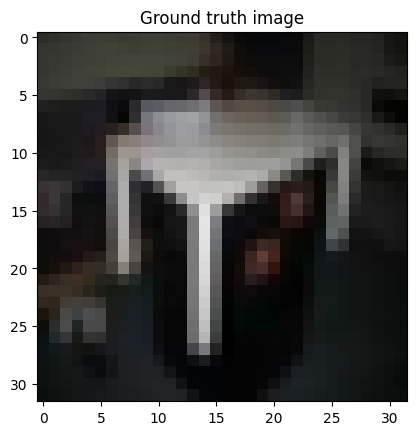

In [4]:
######### honest partipant #########
train_dataset = datasets.CIFAR100(root='./torch', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_criterion = nn.CrossEntropyLoss()
train_optimizer = optim.Adam(model.parameters(), lr=learning_rate)



#攻击用数据
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())
for i in range(epochs):
  if i % 10 != 0:
    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = net(images)
          loss = train_criterion(outputs, labels)

          # Backward and optimize
          train_optimizer.zero_grad()
          loss.backward()
          train_optimizer.step()

          if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  else:
    # img_index = 25
    # gt_data = tp(dst[img_index][0]).to(device)
    # gt_data = gt_data.view(1, *gt_data.size())
    # gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    # gt_label = gt_label.view(1, )
    # gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

    # plt.imshow(tt(gt_data[0].cpu()))
    # plt.title("Ground truth image")
    # print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    # compute original gradient
    out = net(gt_data)
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())


    # share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))
    dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx)


Dummy label is 64.


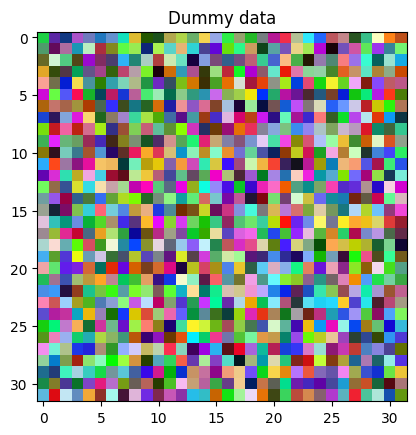

In [5]:
# generate dummy data and label
# dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
# dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

# plt.imshow(tt(dummy_data[0].cpu()))
# plt.title("Dummy data")
# print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [6]:
# optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

# history = []
# for iters in range(300):
#     def closure():
#         optimizer.zero_grad()

#         pred = net(dummy_data)
#         dummy_onehot_label = F.softmax(dummy_label, dim=-1)
#         dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
#         dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

#         grad_diff = 0
#         grad_count = 0
#         for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
#             grad_diff += ((gx - gy) ** 2).sum()
#             grad_count += gx.nelement()
#         # grad_diff = grad_diff / grad_count * 1000
#         grad_diff.backward()

#         return grad_diff

#     optimizer.step(closure)
#     if iters % 10 == 0:
#         current_loss = closure()
#         print(iters, "%.4f" % current_loss.item())
#     history.append(tt(dummy_data[0].cpu()))

0 32.5774
10 0.6287
20 0.1490
30 0.0314
40 0.0055
50 0.0015
60 0.0005
70 0.0002
80 0.0001
90 0.0000
100 0.0000
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000
200 0.0000
210 0.0000
220 0.0000
230 0.0000
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000


Dummy label is 84.


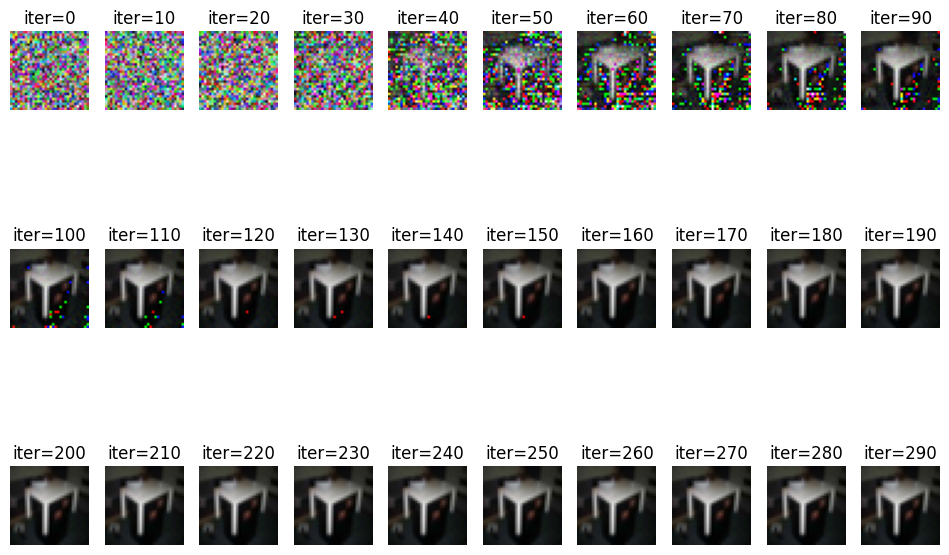

In [7]:
# plt.figure(figsize=(12, 8))
# for i in range(30):
#   plt.subplot(3, 10, i + 1)
#   plt.imshow(history[i * 10])
#   plt.title("iter=%d" % (i * 10))
#   plt.axis('off')
# print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())